<a href="https://colab.research.google.com/github/nithyasri0913/Day-Night-Image-Translations-using-CycleGAN/blob/main/Day_Night_Image_Translations_using_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style='color:lightgreen'>About</h1>

    This notebook uses Cycle GANs to trying to convert high resolution Day cityscapes images to Night images and vice versa. The dataset consists of high resolution Day and Night images. Cycle GANs allows us to use the dataset without any explicit image-target image pairs, by using cycle consistancy loss to ensure that the images retain the semantic and structural components. Hence Cycle GAN builds on top of Pix2Pix GANs, with an additional Cycle Consistency loss.
    
* Pix2Pix Notebook :  https://www.kaggle.com/code/virajkadam/segmenting-cityscapes-with-pix2pix-gans


<h1 style='color:lightgreen'>About Cycle GAN</h1>

    Paper Link : https://www.cs.cmu.edu/~junyanz/projects/CycleGAN/CycleGAN.pdf


    Cycle GANs provide the approach to translate an image from source domain X to target domain Y in absence of paired examples. The goal is to learn a mapping G: X-> Y , and inverse mapping F: Y -> X , and introduce a cycle consistancy loss to enforce F(G(X)) = X and G(F(Y_hat)) = Y_hat.

    The problem that Cycle GANs address can be classified as Image to Image translation. While there are other methods that address the problem with image- target pairs, obtaining these pairs is difficult and expensive. This method is applied for the tasks of style transfer, object transfiguration, and attribute transfer and claims to outperform baseline approaches.



<h2 style='color:lightgreen'>Formulation</h2>

    Our goal is to learn two mapping functions G,F over two domains X,Y ; such that G: X -> Y and F : Y -> X. We can think of X as set of pictures, and Y as the set of paintings, for the task of converting Pictures to Paintings. The functions G and F are Generators.

    We also have adverserial discriminators Dx and Dy, where Dx has the task to discriminating between images from set X (pictures) and set of images generated by F(Y)/X_hat (i.e the image generated by the inverse mapping Generator F). Similarly Dy has the task to discriminating between images from set Y (Paintings) and set of images generated by G(X)/Y_hat  (i.e the image generated by the generator G) .

    We guide the training of the GAN using an objective that has two components :
    1) Adverserial loss: For mapping of input domain to target domain, and vice versa.
    2) Cycle Consistency loss:  For enforcing cycle consistency so that F(G(X)) = X and G(F(Y)) = Y .


<h2 style='color:lightgreen'>Losses</h2>

    1) Adverserial loss :

    Loss for GAN G: LGAN(G,DY ,X,Y ) =Ey∼pdata (y)[log DY (y)] + Ex∼pdata (x)[log(1 −DY (G(x))]

    Loss for GAN F : LGAN(F,DX ,Y,X ) =Ex∼pdata (x)[log Dx (x)] + Ey∼pdata (y)[log(1 −Dx (F(y))]

    Where G tries to generate images similar to domain Y, and Dy tries to to discriminate between generated images and original images.
    Similarly, F tries to generate images similar to domain X, and Dx tries to to discriminate between generated images and original images.

    2) Cycle Consistency loss: The network can learn to map input images to some random set permutations in the output domain, which can match the target distribution.Hence using only a adverserial loss would not guarantee a desired and consistant mapping. Hence we apply Cycle consistance loss to enforce this behavour.

    Forward Cycle Consistancy : x → G(x) → F(G(x)) ≈ x ; where x is the input image domain.

    Backward Cycle Consistancy : y → F(y) → G(F(y)) ≈ y ; where y is the target image domain.

    Cycle loss : Lcyc(G,F) =Ex∼pdata(x) [‖F(G(x)) −x‖1] + Ey∼pdata(y) [‖G(F(y)) −y‖1]


<h2 style='color:lightgreen'>Objective</h2>


    Hence the full loss is:

    L(G,F,DX ,DY) = LGAN(G,DY ,X,Y ) + LGAN(F,DX ,Y,X) + λ * Lcyc(G,F)

<h2 style='color:lightgreen'>Implementation</h2>

    1) Architecture : Used the generator architecture from Johnson et al, with instance normalization. The discriminator uses a PatchGAN, which classifies wheather 70*70 patch in the image is real or fake.
    2) Training Detail:
       a) Adverserial Loss : Replace the Log-likelyhood adverserial loss with the Least Square loss, as it is more stable during training.
       b) Total loss : Used the cycle consistency loss weighting parameter Lambda  = 10 .
       c) Optimization : Used Adam optimizer with LR = 0.0002 for first 100 epoch, linealy decaying into 0 in next 100 epochs. (i.e total 200 epochs)
       d) Batch Size : 1
       c) Training updates: Used history of training images for updating Dx and Dy, using a buffer that stores 50 previously generated images . This reduces model oscillations (from strivastava et al).




In [5]:
# pip install --upgrade tensorflow==2.13

<h2 style='color:green'> Imports </h2>


In [ ]:
import os
import pathlib
import time
import datetime
import imageio
from glob import glob
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from IPython import display
from termcolor import colored
from tqdm import tqdm
from IPython.display import Image
import PIL
from PIL import ImageDraw
from IPython import display

def color_print(print_str,
                 print_color='green'):

    '''print in given  color (default green)'''
    print(colored(print_str,print_color))



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
# pip install git+https://github.com/tensorflow/addons.git

In [ ]:

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f'setting seed to {seed}')


class CFG:

    # Dimension of image
    IMG_WIDTH =  512
    IMG_HEIGHT = 512

    #resize image
    resize_height = 700
    resize_width = 1200

    #the lambda param in loss
    LAMBDA = 10
    #--------train pipe-------------
    BUFFER_SIZE = 100
    # The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
    BATCH_SIZE = 2

    #cache
    cache= 50

    #learning rate
    learning_rate = 0.00025


    seed = 7


set_seed(CFG.seed)

setting seed to 7


<h2 style='color:green'> Data directories </h2>


Image dimensions (683, 1024, 3)


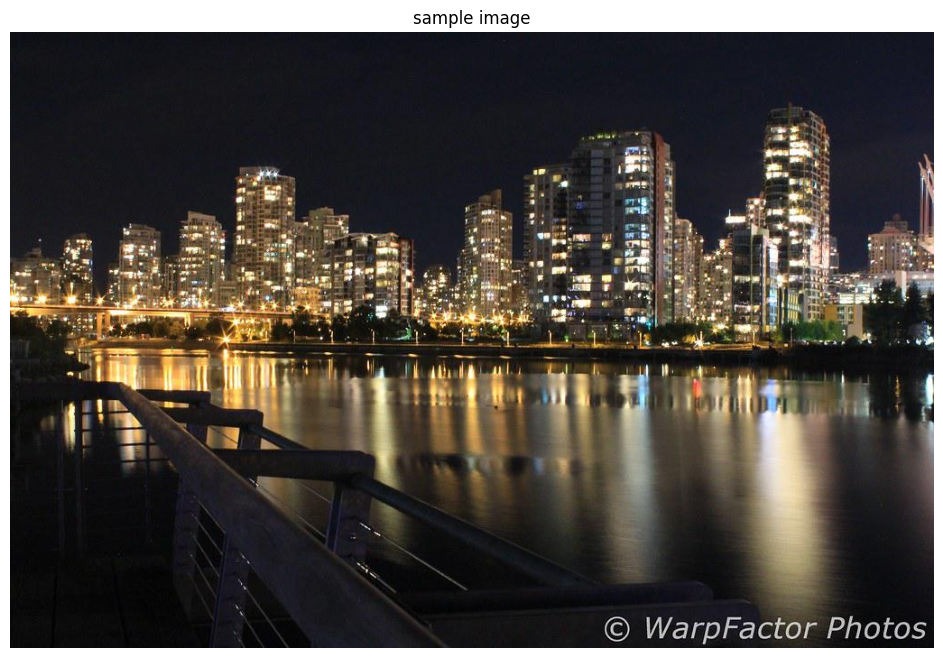

In [ ]:
day_dir = '/content/drive/MyDrive/daynight-cityview/day'
night_dir = '/content/drive/MyDrive/daynight-cityview/night'

# print(day_dir)
#plotting a sample image
plt.figure(figsize=(16,8))

# img = plt.imread(day_dir + '/' + os.listdir(day_dir)[0])
img = plt.imread(night_dir + '/' + os.listdir(night_dir)[0])
plt.imshow(img)
plt.axis('off')
plt.title('sample image')
print(f'Image dimensions {img.shape}')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2 style='color:green'> building data loading pipeline </h2>


In [ ]:
def load_image(image_file):
    '''load a image file'''
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    return image


def random_crop(image):
    '''randomly crop image into defined size '''
    cropped_image = tf.image.random_crop(image, size=[CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3])

    return cropped_image


def normalize(image):
    '''normalizing the images to [-1, 1]'''
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image


def de_normalize(image):
    '''De normalize the image to be in range (0,1)'''

    return (image * 0.5) + 0.5


In [ ]:
def image_augmentations(image):
    '''perform spatial augmentations (rotation and flips) on input image

    from : https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings'''


    # --------------------rotations----------
    #rotation probabliity
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º



    # ----------------------Flips---------------------
    p_flip = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    if p_flip > 0.7:
        image = tf.image.random_flip_left_right(image)
    elif p_flip < 0.3:
        image = tf.image.random_flip_up_down(image)

    return image

In [ ]:
def random_jitter(image):
    '''resize and randommly crop the input image'''

#     # resizing image
    image = tf.image.resize(image, size=(CFG.resize_height, CFG.resize_width),
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 512,512
    image = random_crop(image)

    return image


def preprocess_image_train(image):
    image = load_image(image)
    image = random_jitter(image)
    image= image_augmentations(image)
    image = normalize(image)
    return image


#same function, withou the augemntation
def preprocess_image_eval(image):
    image = load_image(image)
    image = random_jitter(image)
    image = normalize(image)
    return image



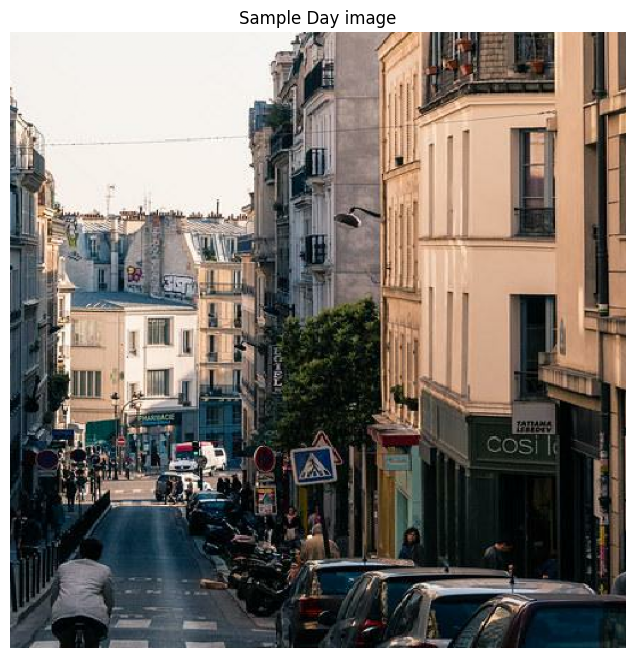

In [ ]:


def create_img_dataset(directory,
                       image_preprocess_fn,
                       image_extension = 'jpg',
                       repeat=True
                      ):
    '''create a tf dataset object from a directory of images'''
    img_list = glob(directory+f'/*{image_extension}')

    dataset = tf.data.Dataset.list_files(img_list)

    dataset = dataset.map(image_preprocess_fn,
                          num_parallel_calls=tf.data.AUTOTUNE)

    if repeat :
        dataset = dataset.repeat()

    dataset = dataset.shuffle(CFG.BUFFER_SIZE)
    dataset = dataset.batch(CFG.BATCH_SIZE)
    return dataset


Day_Dataset = create_img_dataset(directory = day_dir,image_preprocess_fn = preprocess_image_train)

#without augmentation
Day_eval = create_img_dataset(directory = day_dir,
                            image_preprocess_fn = preprocess_image_eval)



fig,ax = plt.subplots(figsize=(16,8))

inp_img = next(iter(Day_Dataset))
plt.imshow(de_normalize(inp_img[0]))
plt.title('Sample Day image')
plt.axis('off')

plt.show()

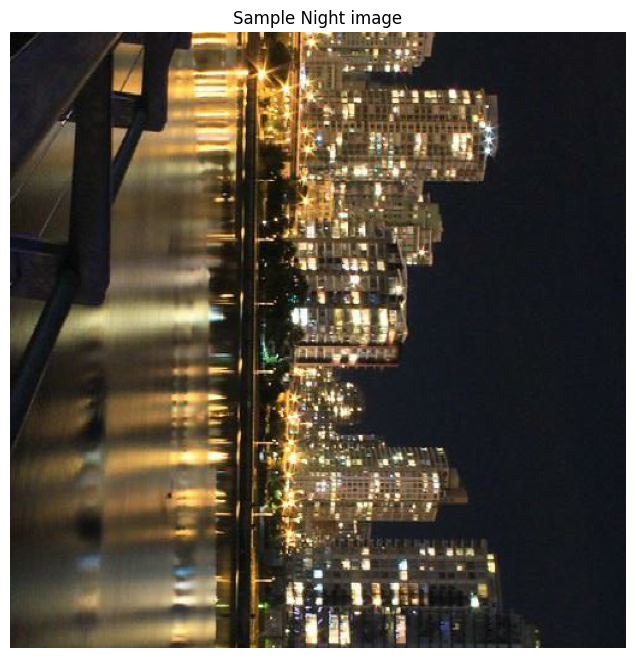

In [ ]:
Night_Dataset = create_img_dataset(directory = night_dir,image_preprocess_fn = preprocess_image_train)
Night_eval = create_img_dataset(directory = night_dir, image_preprocess_fn = preprocess_image_eval)
fig,ax = plt.subplots(figsize=(16,8))


inp_img = next(iter(Night_Dataset))
plt.imshow(de_normalize(inp_img[0]))
plt.title('Sample Night image')
plt.axis('off')

plt.show()


In [ ]:
# train data set

Train_Dataset = tf.data.Dataset.zip((Day_Dataset,Night_Dataset))
print(Train_Dataset)

<_ZipDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>


<h2 style='color:green'> Building Model</h2>


**Upsampling and downsampling blocks**

In [ ]:

#conv weights initilaizer
conv_initializer = tf.random_normal_initializer(mean=0.0,
                                                stddev=0.02)

#init for intance normalization
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                       stddev=0.02)




def downsample(input_layer,
               filters,
               name,
               size=3,
               strides=2,
               activation=tf.keras.layers.ReLU(),
               ):

    '''perform a downsampling by applying a convolution,followed by instance norm and activation'''
    conv = tf.keras.layers.Conv2D(filters,
                                  size,
                                  strides=strides,
                                  padding='same',
                                  use_bias=False,
                                  kernel_initializer=conv_initializer,
                                  name=f'encoder_{name}')(input_layer)


    conv = tfa.layers.InstanceNormalization(axis=-1,gamma_initializer=gamma_initializer)(conv)
    conv = activation(conv)

    return conv


def upsample(input_layer,
             filters,
             name,
             size=3,
             strides=2,
             activation='relu'):

    res = tf.keras.layers.Conv2DTranspose(filters, size,
                                          strides=strides,
                                          padding='same',
                                          use_bias=False,
                                          kernel_initializer=conv_initializer,
                                          name=f'decoder_{name}')(input_layer)

    res = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(res)
    res =  tf.keras.layers.Activation(activation)(res)

    return res

**Residual block**

In [ ]:

def residual_block(input_layer,
                   size=3,
                   strides=1,
                   name='block_x'):
    '''performs 2 convolutions followed by an added skip connection with the input'''


    filters = input_layer.shape[-1]
    block = tf.keras.layers.Conv2D(filters,
                     size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'residual_{name}')(input_layer)

    block = tf.keras.layers.Activation('relu')(block)
    block = tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)

    #skip connection
    res = tf.keras.layers.Add()([block, input_layer])

    return res


def concat_layer(layer_1,layer_2,name):
    '''concatenation of layers for skip connections'''
    return tf.keras.layers.Concatenate(name=name)([layer_1,layer_2])


<h3 style='color:lightgreen'> Building Generator</h3>


In [ ]:
def get_generator(num_residual_connections=6):

    input_ = tf.keras.layers.Input(shape=(CFG.IMG_WIDTH,CFG.IMG_HEIGHT,3),
                                   name='input_layer')

    #-----------------------ENCODER-------------------------------
    #downsample images
    enc1 = downsample(input_layer = input_, filters=64,  strides =  1, size=7, name='dwn_1')    # (bs, 512,512, 64)
    enc2 = downsample(input_layer=enc1,filters= 128,size =  3, strides =  2, name='dwn_2')      # (bs, 256, 256, 128)
    enc3 = downsample(input_layer=enc2, filters=256,size =  3, strides =2, name='dwn_3')        # (bs, 128,128,256)
    enc4 = downsample(input_layer=enc3, filters=256,size =  3, strides =2, name='dwn_4')        # (bs, 64,64,256)


    #-----------------------Residual connections-------------------------------
    x = enc4
    for n in range(num_residual_connections):
        x = residual_block(input_layer=x, name=f'res_block_{n+1}')     # (bs, 64, 64, 256)

    #-----------------------DECODER-------------------------------
    #UNET like skip connection
    #upsample 1
    x_skip = concat_layer(layer_1=x,layer_2=enc4,name='skip_1')
    dec1 = upsample(x_skip,filters=256 ,name='upsam_1')  # (bs, 128, 128, 256)

    #upsample 2
    x_skip = concat_layer(layer_1=dec1,layer_2=enc3,name='skip_2')
    dec_2 = upsample(x_skip, filters=128,name='upsam_2') # (bs, 256, 256, 128)

    #upsample 3
    x_skip = concat_layer(layer_1=dec_2,layer_2=enc2,name='skip_3')
    dec_3 = upsample(x_skip, filters= 64,name='upsam_3') # (bs, 512, 512, 64)

    #penultimate
    x_skip = concat_layer(layer_1=dec_3,
                          layer_2=enc1,
                          name='skip_final')

    output = tf.keras.layers.Conv2D(filters = 3,kernel_size = 7, strides=1, padding='same',
                                  kernel_initializer=conv_initializer, use_bias=False, activation='tanh',
                                  name='output_layer')(x_skip)


    return tf.keras.models.Model(inputs=input_,outputs=output)




# day images -> night images
day2night_gen = get_generator()

# night images -> day images
night2day_gen = get_generator()


#plot model
# tf.keras.utils.plot_model(day2night_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


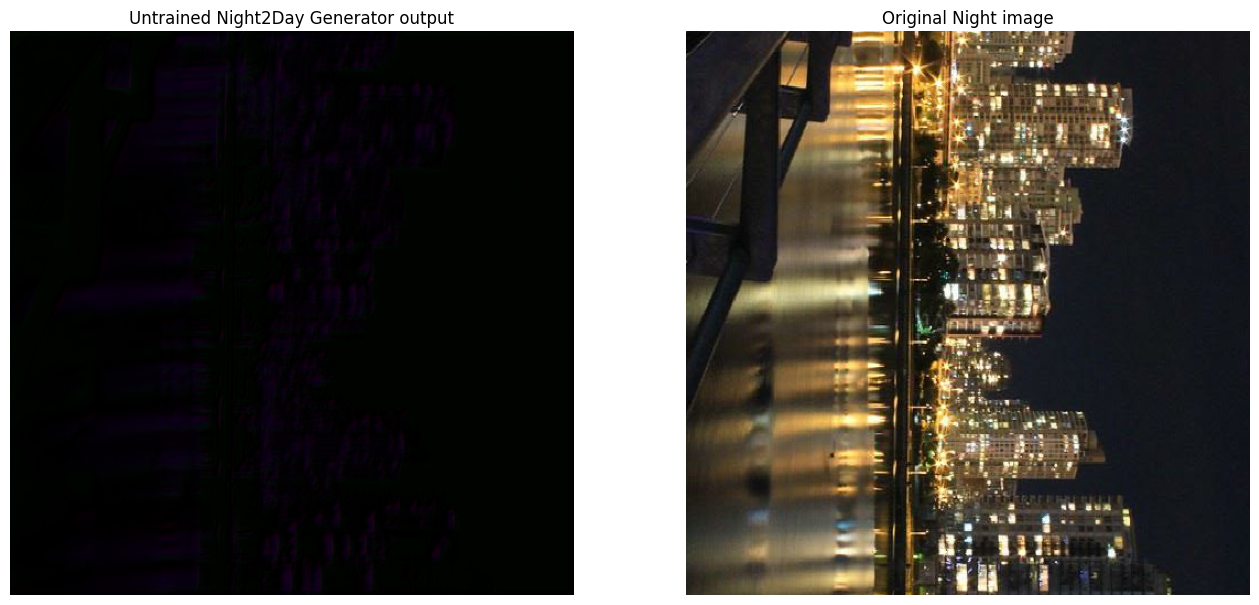

In [ ]:
#passing in a input to generator for check
#plot a sample output
gen_output = night2day_gen(inp_img, training=False)[0]
plt.subplots(1,2,figsize=(16,8))


plt.subplot(1,2,1)
plt.imshow(gen_output.numpy().squeeze())
plt.title('Untrained Night2Day Generator output')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(de_normalize(inp_img[0]))
plt.title('Original Night image')
plt.axis('off')

plt.show()

<h3 style='color:green'> Building Discriminator</h3>


In [ ]:


def PATCH_discriminator(leak_rate = 0.2):
    '''PATCH discriminator network'''
    leaky_relu = tf.keras.layers.LeakyReLU(leak_rate)


    input_ = tf.keras.layers.Input(shape=(CFG.IMG_WIDTH,CFG.IMG_HEIGHT,3),
                               name='input_layer')
    # Encoder
    # Input image 512,512
    x = downsample(input_layer = input_, filters=64,  strides =  2, size=4, name='dwn_1',activation = leaky_relu)    #h,w =256
    x = downsample(input_layer = x, filters=128,  strides =  2, size=4, name='dwn_2',activation = leaky_relu)        #h,w =128
    x = downsample(input_layer = x, filters=256,  strides =  2, size=4, name='dwn_3',activation = leaky_relu)        #h,w = 64
    x = downsample(input_layer = x, filters=512,  strides =  2, size=4, name='dwn_4',activation = leaky_relu)        #h,w = 32
    x = downsample(input_layer = x, filters=512,  strides =  1, size=4, name='dwn_5',activation = leaky_relu)        #h,w = 32


    output = tf.keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)         #(29, 29, 1)

    return tf.keras.models.Model(inputs=input_,outputs=output)



#create instance of discriminators
day2night_disc = PATCH_discriminator()  # identify night images
night2day_disc = PATCH_discriminator()  # identify day images


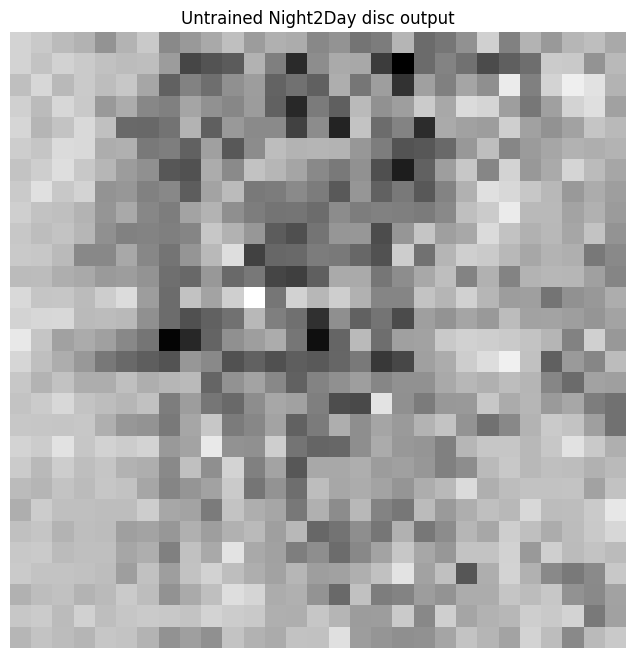

In [ ]:
#check on dicriminator

disc_output = day2night_disc(inp_img, training=False)
plt.subplots(1,1,figsize=(8,8))

plt.imshow(disc_output.numpy().mean(axis=0),cmap='gray')
plt.title('Untrained Night2Day disc output')
plt.axis('off')

plt.show()

In [ ]:
def generate_cycle(gen_1,gen_2,input_image):
    '''generate a full cycle of images using given generators'''
    gen_img_1 = gen_1(input_image,training=True)
    gen_img_2 = gen_2(gen_img_1,training=True)

    return gen_img_1,gen_img_2


def calc_and_apply_gradients(tape,
                             model,
                             loss,
                             optimizer):
    '''Apply gradients for a given model using given optimizer'''

    #calculate gradients of loss function
    gradients = tape.gradient(loss,model.trainable_variables)

    #apply gradients
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    return

<h3 style='color:green' >losses </h3>

In [ ]:
def discriminator_loss(real, generated):
    '''discriminator Binary CrossEntropy loss'''
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

# Generator Adverserial loss
def generator_loss(generated):
    '''adverserial generator loss (BCE)'''
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)


# Cycle consistency loss

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    '''pixel wise cycle loss between original image and cycled image'''
    mae_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * mae_loss


# identity loss
def identity_loss(real_image, same_image, LAMBDA):
    mae_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * mae_loss

<h2 style='color:green'>Cycle GAN</h2>


In [ ]:
class CycleGAN(tf.keras.models.Model):
    def __init__(self,
                 lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.gen_d2n = day2night_gen # Day -> Night
        self.gen_n2d = night2day_gen # Night -> Day
        self.disc_d2n = day2night_disc # Classifies Night Images
        self.disc_n2d = night2day_disc # Classifier Day Images
        self.lambda_cycle = lambda_cycle #lambda in cycle consistancy loss

    def compile(self,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn,
                common_opt = tf.keras.optimizers.Adam(learning_rate = CFG.learning_rate,beta_1 = 0.5)):

        super(CycleGAN, self).compile()

        # -------optimizers ---------
        self.opt_gen_d2n = common_opt
        self.opt_gen_n2d = common_opt
        self.opt_disc_d2n = common_opt
        self.opt_disc_n2d = common_opt


        # -------losses ---------
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn


    def train_step(self, batch_data):
        day_image, night_image = batch_data

        with tf.GradientTape(persistent=True) as tape:

            #-----day->night->day
            fake_night,cycled_day = generate_cycle(self.gen_d2n,
                                                     self.gen_n2d,
                                                     day_image)


            # --------night -> day- > night
            fake_day,cycled_night = generate_cycle(self.gen_n2d,
                                                   self.gen_d2n,
                                                   night_image)

            #---------- generating itself (for identity loss)
            iden_day = self.gen_d2n(night_image, training=True)
            iden_night = self.gen_n2d(day_image, training=True)

            # -----------discriminator on real images
            disc_night = self.disc_d2n(night_image, training=True)
            disc_day = self.disc_n2d(day_image, training=True)

            # -----------discriminator on fake images-----------------
            disc_fake_night   = self.disc_d2n(fake_night, training=True)
            disc_fake_day = self.disc_n2d(fake_day, training=True)

            # -------------------------generator loss-------------
               #---1)adverserial loss
            night_gen_loss = self.gen_loss_fn(disc_fake_night)
            day_gen_loss = self.gen_loss_fn(disc_fake_day)

                #---2)Cycle loss loss
            total_cycle_loss = self.cycle_loss_fn(night_image, cycled_night, self.lambda_cycle) + self.cycle_loss_fn(day_image, cycled_day, self.lambda_cycle)

                # +++++3) Total Gen loss (day gen and night gen)
            total_gen_d2n_loss = night_gen_loss + total_cycle_loss + self.identity_loss_fn(night_image, iden_night,self.lambda_cycle)
            total_gen_n2d_loss = day_gen_loss + total_cycle_loss + self.identity_loss_fn(day_image, iden_day, self.lambda_cycle)


            # -------------------------Discriminator loss-------------
            night_disc_loss = self.disc_loss_fn(disc_night, disc_fake_night)  # check classifying generated and real night
            day_disc_loss = self.disc_loss_fn(disc_day, disc_fake_day)        # check  classifying generated and real day

        ## ------------------------- Calculating and Updating gradients------------------

        # day->night gen gradeints
        _ = calc_and_apply_gradients(tape=tape,
                                     model= self.gen_d2n,
                                     loss = total_gen_d2n_loss,
                                     optimizer = self.opt_gen_d2n)

        # night - >day  gen gradeints
        _ = calc_and_apply_gradients(tape=tape,
                                     model= self.gen_n2d,
                                     loss = total_gen_n2d_loss,
                                     optimizer = self.opt_gen_n2d)

        #  discrim gradients (classifies night images)
        _ = calc_and_apply_gradients(tape=tape,
                                     model= self.disc_d2n,
                                     loss = night_disc_loss,
                                     optimizer = self.opt_disc_d2n)

        # Day discrim gradients (classifies day images)
        _ = calc_and_apply_gradients(tape=tape,
                                     model= self.disc_n2d,
                                     loss = day_disc_loss,
                                     optimizer = self.opt_disc_n2d)


        return {'gen_D2N_loss': total_gen_d2n_loss,
                'gen_N2D_loss': total_gen_n2d_loss,
                'disc_day_loss': day_disc_loss,
                'disc_night_loss': night_disc_loss
               }




In [ ]:
#creat a instance of Cycle gan
gan = CycleGAN()


#complie with the losses
gan.compile(gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss,
            identity_loss_fn=identity_loss)
# print(gan.summary())

NameError: name 'CycleGAN' is not defined

<h3 style='color:green'>Callbacks</h3>

        For reducing Learning Rate,stopping training and Visulization

In [ ]:
#learning rate schedule

def scheduler(epoch,
              lr,
              decay_rate = 0.05,
              warm_up_period = 10):

    if epoch < warm_up_period:
        return lr
    elif (epoch > warm_up_period and epoch<40):
        return lr * tf.math.exp(decay_rate)
    else:
        return lr * tf.math.exp(decay_rate*2)




lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                        verbose = 0)


#early stopping

# early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'gen_N2D_loss',
#                                               mode = 'min',
#                                               patience = 10,
#                                              restore_best_weights = True)

NameError: name 'tf' is not defined

In [ ]:
# early stopping : from https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):

        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.n2d_loss = np.Inf
        self.d2n_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        n2d_loss=logs.get('gen_N2D_loss')
        d2n_loss=logs.get('gen_D2N_loss')

        # If both the conditions are met, continue training
        if (np.less(n2d_loss, self.n2d_loss) and np.less(d2n_loss, self.d2n_loss)):
            self.d2n_loss = d2n_loss
            self.n2d_loss = n2d_loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()

        # if above xondition not met, continue training till patiance epochs
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
#--------------------------------------Viz Callbacks : from https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings -----------------------------------------
def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)

        f = plt.figure(figsize=(16,8))

        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()

    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)

        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')

        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')

        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')

    plt.show()

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

# Callback
class GANMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self,
                 num_img=1,
                 day_paths='generated_day',
                 night_paths='generated_night'):
        self.num_img = num_img
        self.day_paths = day_paths
        self.night_paths = night_paths
        print("day_paths: ",num_img, day_paths)
        # dir to save genereated day images
        if not os.path.exists(self.day_paths):
            os.makedirs(self.day_paths)


        # dir to save genereated night images
        if not os.path.exists(self.night_paths):
            os.makedirs(self.night_paths)



    def on_epoch_end(self, epoch, logs=None):
        #generated night
        for i, img in enumerate(Day_eval.take(self.num_img)):
            print("on_epoch_end: ",i)

            prediction = day2night_gen(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.night_paths}/generated_{i}_{epoch+1}.png')

        # generated day images
        for i, img in enumerate(Night_eval.take(self.num_img)):
            prediction = night2day_gen(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.day_paths}/generated_{i}_{epoch+1}.png')

<h2 style='color:green'>Fitting the model</h2>


In [ ]:
EPOCHS = 1
callbacks = [lr_scheduler,GANMonitor(),CustomEarlyStopping(patience = 1)]
steps_per_epoch = 10

print(Train_Dataset, callbacks)
history = gan.fit(Train_Dataset,
                epochs = EPOCHS,
                steps_per_epoch=steps_per_epoch,
                callbacks = callbacks)

NameError: name 'lr_scheduler' is not defined

<h2 style='color:green'>Visualizing Training Progress</h2>

<h3 style='color:lightgreen'> Visualizing Training Progress for Night -> Day generator</h3>



In [ ]:


# from https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings
def create_gif(images_path, gif_path):
    images = []
    filenames = glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif



create_gif('./generated_day/*.png', 'day.gif')

print('Training progress for Night -> Day Generator')
display.Image('./day.gif')

ValueError: need at least one array to stack

<iframe src="./day.gif" height="300"
        style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Training Progress - Day"></iframe>

<h3 style='color:lightgreen'> Visualizing Training Progress for Day -> Night generator</h3>


In [ ]:
create_gif('./generated_night/*.png', 'night.gif')


print('Training progress for Day-> Generator')
display.Image('./night.gif')

<h1 style='color:green'>Results</h1>


<h2 style='color:lightgreen'>Evaluating Day -> Night Generator</h2>


In [ ]:
display_generated_samples(Day_eval.take(2), day2night_gen, 2)

In [ ]:
display_generated_samples(Day_eval.take(2), day2night_gen, 2)

In [ ]:
display_generated_samples(Day_eval.take(2), day2night_gen, 2)

<h2 style='color:lightgreen'>Evaluating Night -> Day Generator</h2>


In [ ]:
display_generated_samples(Night_eval.take(2), night2day_gen, 2)

In [ ]:
display_generated_samples(Night_eval.take(2), night2day_gen, 2)

In [ ]:
display_generated_samples(Night_eval.take(2), night2day_gen, 2)

<h2 style='color:lightgreen'>Evaluating Identity for Day to Night Generator so that Night -> Night </h2>


In [ ]:
display_generated_samples(Night_eval.take(2), day2night_gen, 2)

In [ ]:
display_generated_samples(Night_eval.take(2), day2night_gen, 2)

In [ ]:
display_generated_samples(Night_eval.take(2), day2night_gen, 2)

<h2 style='color:lightgreen'>Evaluating Identity for Night to Day Generator so that Day -> Day </h2>


In [ ]:
display_generated_samples(Day_eval.take(2), night2day_gen, 2)

In [ ]:
display_generated_samples(Day_eval.take(2), night2day_gen, 2)

In [ ]:
display_generated_samples(Day_eval.take(2), night2day_gen, 2)

<h2 style='color:lightgreen'>Cycle : Day(real image) -> Night -> Day</h2>


In [ ]:
evaluate_cycle(Day_eval.take(2),
               day2night_gen,
               night2day_gen,
               n_samples=2)

In [ ]:
evaluate_cycle(Day_eval.take(2),
               day2night_gen,
               night2day_gen,
               n_samples=2)

<h2 style='color:lightgreen'>Cycle : Day(real image) -> Night -> Day</h2>


In [ ]:
evaluate_cycle(Night_eval.take(2),
               night2day_gen,
               day2night_gen,
               n_samples=2)


In [ ]:
evaluate_cycle(Night_eval.take(2),
               night2day_gen,
               day2night_gen,
               n_samples=2)

# References and Resources

* https://www.cs.cmu.edu/~junyanz/projects/CycleGAN/CycleGAN.pdf
* https://www.tensorflow.org/tutorials/generative/cyclegan
* https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings
